# MVP e-CHURN XGBoost

### Material de referência.
xgboos: https://gist.github.com/pb111/cc341409081dffa5e9eaf60d79562a03
shap: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
lime: https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions#lime_tabular


### Etapas:
- Carga de bibliotecas e bases
- Preparação de dados
- Roda modelo simples
- Faz validação cruzada
- Pega aprendizados de modelo e variáveis e aplica modelo otimizado

## Carga de bibliotecas e bases

In [ ]:
#Carregar bibliotecas e setar parâmetros
!pip install xgboost
!pip install skimpy
!pip install shap
!pip install openpyxl
!pip install lime
!pip install --upgrade pandas==1.2
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
from lime import lime_tabular
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from skimpy import clean_columns #limpar nomes de coluna
import matplotlib.pyplot as plt #graficos
#import re #expressoes regulares
import numpy as np
import seaborn as sns
import shap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Pre tratamento dos dados

In [2]:
# Ler e preparar base

df_base = pd.read_excel('Neon_Indicadores_202209.xlsx')

df_base=df_base[df_base['neon']==1]  #desconsiderando CNPJ Consiga+
df_base=df_base[df_base['e_gec']==0]  # Desc. Geek    #Verificar % da Base
df_base=df_base[df_base['macro_area']=="CdE de Tech"]  #Selecionar só 1 dir

#limpar variaveis que não fazem sentido
df = df_base.drop(['macro_area','cpf','nome','macro_area'],axis=1,inplace=False)


df.head(5)

,neon,Status,treino,Sexo,BH_Positivo,BH_Negativo,N_colaborador,e_gestr,Tempo de casa,UF,...,promo_2_anos,Temp_CARGO,merito_6_meses,merito_12_meses,merito_2_anos,Nota Final,Perfomance,Cultura,Autoavaliacao,Pares
0,1,0,0,MASCULINO,0.0,0.0,5,0,17.0,SP,...,0,17,0,0,0,3.100000,3.0,3.3100,4.00,3.25
3,1,0,0,MASCULINO,0.0,0.0,5,0,11.0,SP,...,0,11,1,1,1,3.261833,3.0,3.7855,3.00,3.35
4,1,0,0,MASCULINO,0.0,0.0,5,0,2.0,SP,...,0,2,0,0,0,0.000000,0.0,0.0000,0.00,0.00
5,1,0,0,MASCULINO,0.0,0.0,4,0,11.0,SP,...,0,11,1,1,1,3.540000,3.0,3.6300,3.00,3.58
13,1,0,0,FEMININO,0.0,0.0,5,0,7.0,SP,...,0,7,0,0,0,2.820000,3.0,2.9600,3.67,2.92


In [3]:
df.columns

Index(['neon', 'Status', 'treino', 'Sexo', 'BH_Positivo', 'BH_Negativo',
       'N_colaborador', 'e_gestr', 'Tempo de casa', 'UF', 'Agil', 'nivel',
       'Tempo_Grupo', 'cor', 'Persona', 'socio', 'perc_faixa', 'posicao',
       'Idade', 'e_gec', 'Promo_6_meses', 'Promo_12_meses', 'promo_2_anos',
       'Temp_CARGO', 'merito_6_meses', 'merito_12_meses', 'merito_2_anos',
       'Nota Final', 'Perfomance', 'Cultura', 'Autoavaliacao', 'Pares'],
      dtype='object')

In [4]:
# Tratamento dos dados

# Quebra variaveis categoricas em multiplas 1 e 0
#sexo de um homem vira sexo_masculino=1 e sexo_feminino=0
base = pd.get_dummies(df)

#conserta nomes das colunas
base = clean_columns(base)

64 column names have been cleaned

In [5]:
base.columns

Index(['neon', 'status', 'treino', 'bh_positivo', 'bh_negativo',
       'n_colaborador', 'e_gestr', 'tempo_de_casa', 'agil', 'socio',
       'perc_faixa', 'idade', 'e_gec', 'promo_6_meses', 'promo_12_meses',
       'promo_2_anos', 'temp_cargo', 'merito_6_meses', 'merito_12_meses',
       'merito_2_anos', 'nota_final', 'perfomance', 'cultura', 'autoavaliacao',
       'pares', 'sexo_feminino', 'sexo_masculino', 'uf_al', 'uf_am', 'uf_ba',
       'uf_ce', 'uf_df', 'uf_es', 'uf_go', 'uf_ma', 'uf_mg', 'uf_mt', 'uf_pa',
       'uf_pb', 'uf_pe', 'uf_pi', 'uf_pr', 'uf_rj', 'uf_rn', 'uf_rs', 'uf_sc',
       'uf_se', 'uf_sp', 'uf_sp_1', 'nivel_anl_i', 'nivel_anl_ii',
       'nivel_anl_iii', 'nivel_esp_coord', 'nivel_gte', 'nivel_head',
       'nivel_lid_cd', 'tempo_grupo_12', 'tempo_grupo_3', 'tempo_grupo_6',
       'tempo_grupo_12_1', 'cor_amarela', 'cor_branca', 'cor_indigena',
       'cor_nao_informada', 'cor_parda', 'cor_preta', 'persona_esta_voando',
       'persona_mandando_bem', 'persona_n

In [6]:
# Separa em treino e teste
base_treino = base[base['treino']==1]
base_teste = base[base['treino']==0]

# seleciona variáveis
lista_var = [
       #'neon', 
       #'bh_positivo', 'bh_negativo',
       #'n_colaborador', 
       'e_gestr', 
       'tempo_de_casa', #'agil', 'socio',
       'perc_faixa', 
       'idade', #'e_gec', 
       #'promo_6_meses', 
       'promo_12_meses',
       #'promo_2_anos', 
       'temp_cargo', 
       'merito_6_meses', 
       #'merito_12_meses',
       #'merito_2_anos', #
       #'nota_final', 'perfomance', 'cultura', 'autoavaliacao', 'pares', 
       'sexo_feminino', 'sexo_masculino', 
       #'uf_al', 'uf_am', 'uf_ba',
       #'uf_ce', 'uf_df', 'uf_es', 'uf_go', 'uf_ma', 'uf_mg', 'uf_ms', 'uf_mt',
       #'uf_pa', 'uf_pb', 'uf_pe', 'uf_pi', 'uf_pr', 'uf_rj', 'uf_rn', 'uf_ro',
       #'uf_rs', 'uf_sc', 'uf_se', 
       'uf_sp', #'uf_sp_1', 'nivel_anl_i',
       #'nivel_anl_ii', 'nivel_anl_iii', 'nivel_esp_coord', 'nivel_gte',
       #'nivel_head', 'nivel_lid_cd', 'nivel_ope', 'nivel_spv',
       #'tempo_grupo_12', 'tempo_grupo_3', 'tempo_grupo_6', 'tempo_grupo_12_1',
       #'cor_amarela', 'cor_branca', 'cor_indigena', 'cor_nao_informada',
       #'cor_parda', 'cor_preta',
       'persona_esta_voando', 'persona_mandando_bem',
       'persona_nao_avaliado', #'persona_pode_mais' #, 'persona_precisa_agir',
       'posicao_1_abaixo', 'posicao_2_dentro', 'posicao_3_acima'
            ]

y_treino = base_treino['status']
x_treino = base_treino[lista_var]

y_teste = base_teste['status']
x_teste = base_teste[lista_var]

base_treino = base_treino[lista_var]
base_teste = base_teste[lista_var]

# Visão das primeiras linhas da tabela
base_treino.head(5)

,e_gestr,tempo_de_casa,perc_faixa,idade,promo_12_meses,temp_cargo,merito_6_meses,sexo_feminino,sexo_masculino,uf_sp,persona_esta_voando,persona_mandando_bem,persona_nao_avaliado,posicao_1_abaixo,posicao_2_dentro,posicao_3_acima
2120,0,14.366667,0.970005,48,0,14,0,0,1,1,0,1,0,0,1,0
2123,0,8.766667,0.800055,28,0,8,1,0,1,1,0,1,0,0,1,0
2124,0,8.766667,0.925046,32,0,8,0,0,1,1,0,1,0,0,1,0
2132,0,4.566667,1.000000,42,0,4,0,1,0,1,0,0,1,0,1,0
2136,0,1.300000,0.957756,25,0,1,0,1,0,0,0,0,1,0,1,0


In [7]:
len(lista_var)

16

In [8]:
# Construção de modelo simples
params = {
            'objective':'binary:logistic',
            'learning_rate': 1.0,   # Ajuda a prevenir overfitting
            'max_depth': 15,         # Profundidade maxima por arvore 
            'subsample':1,          # % de amostras por arvore
            'colsample_bytree':0.5, # % de cats por arvore
            'n_estimators':100,      # num de arvores 
            'seed':42               # manter reprodutibilidade
        }

# Modelo
modelo_xgb = XGBClassifier(**params)

# Faz previsão
modelo_xgb.fit(x_treino, y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [9]:
# Faz previsao no conjunto de teste
y_pred = modelo_xgb.predict(x_teste)

In [10]:
# Matriz de confusão
cm = confusion_matrix(y_teste, modelo_xgb.predict(x_teste))
  
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
  
print(cm)
print()
print('Ativos previstos corretamente = "{0:0.0f}"'.format(TN))
print()
print('Desligados previstos corretamente = "{0:0.0f}"'.format(TP))
print()
print('Ativos previstos como desligados = "{0:0.0f}"'.format(FP))
print()
print('Desligados previstos como ativos = "{0:0.0f}"'.format(FN))
print()
print('Acurácia = {0:0.2f}'.format((TP + TN) / (TP + TN + FN + FP)))

print()
print('Sensibilidade = {0:0.2f}'.format(TP/(TP+FN)))

print()
print('Especificidade  = {0:0.2f}'.format(FN/(FN+FP)))



[[359 122]
 [  4   2]]

Ativos previstos corretamente = "359"

Desligados previstos corretamente = "2"

Ativos previstos como desligados = "122"

Desligados previstos como ativos = "4"

Acurácia = 0.74

Sensibilidade = 0.33

Especificidade  = 0.03


In [11]:
print(classification_report(y_teste, modelo_xgb.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       481
           1       0.02      0.33      0.03         6

    accuracy                           0.74       487
   macro avg       0.50      0.54      0.44       487
weighted avg       0.98      0.74      0.84       487



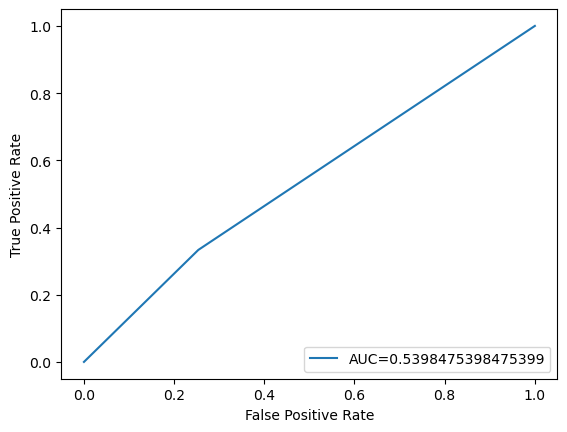

In [12]:
# Curva ROC
fpr, tpr, _ = metrics.roc_curve(y_teste,  y_pred)
auc = metrics.roc_auc_score(y_teste, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

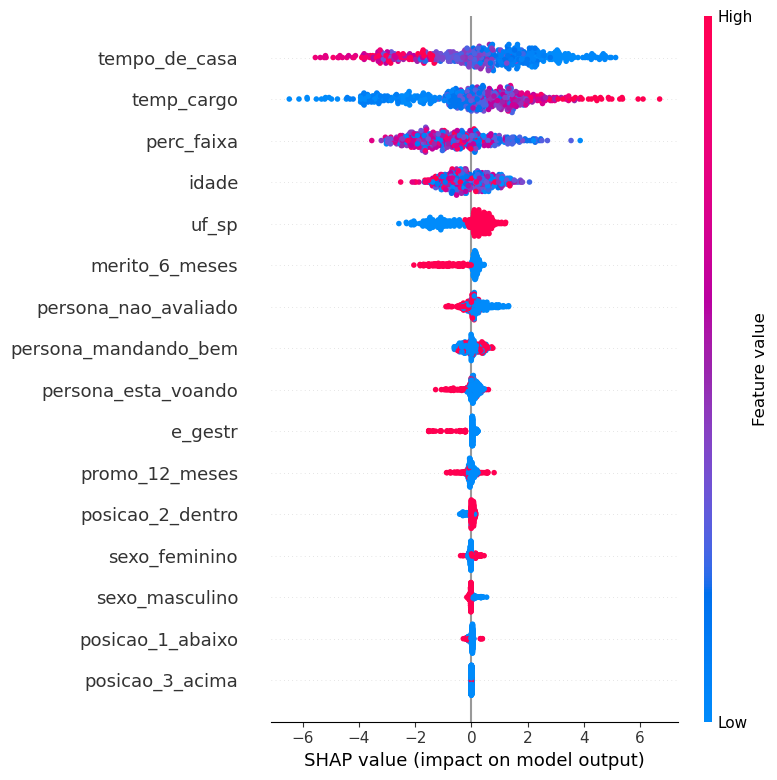

In [13]:
# make sure the SHAP values add up to marginal predictions
pred = modelo_xgb.predict(x_teste, output_margin=True)
explicador = shap.TreeExplainer(modelo_xgb)
shap_values = explicador.shap_values(x_teste)
np.abs(shap_values.sum(1) + explicador.expected_value - pred).max()

shap.summary_plot(shap_values, x_teste)



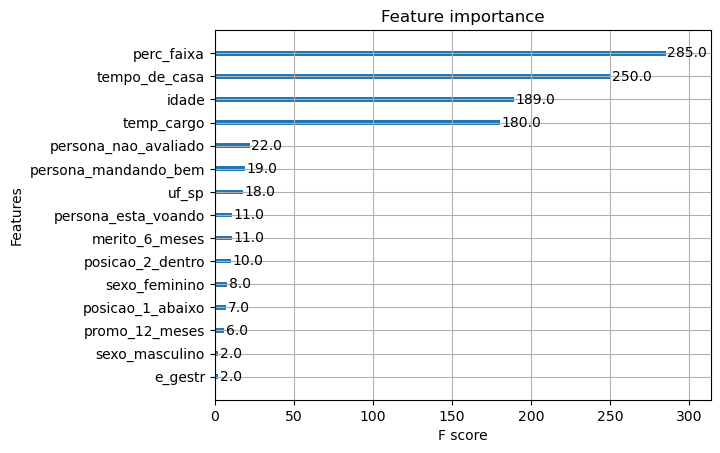

In [14]:
xgb.plot_importance(modelo_xgb)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

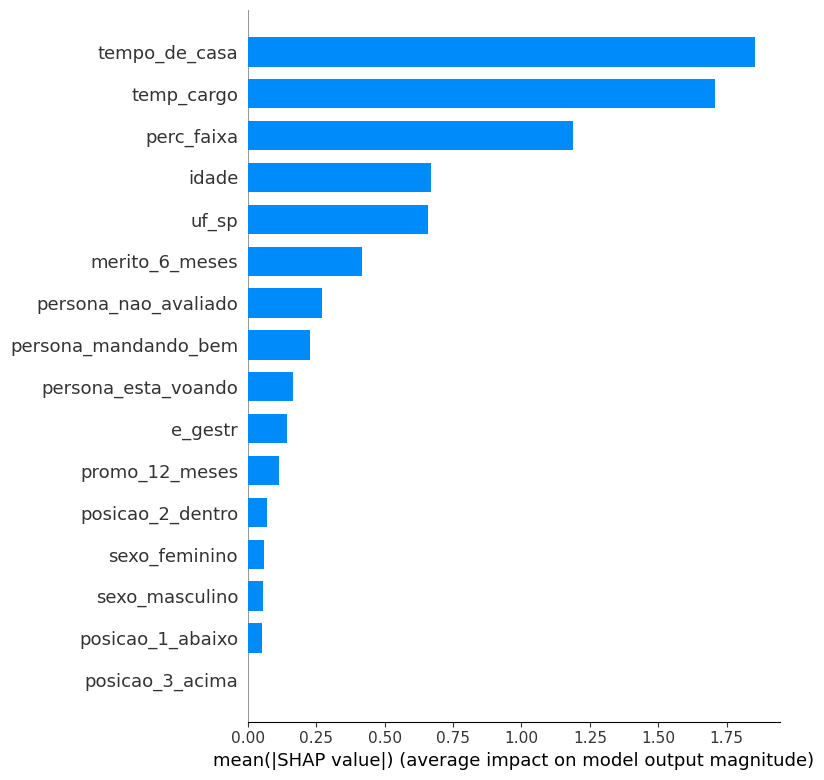

In [15]:
# make sure the SHAP values add up to marginal predictions
pred = modelo_xgb.predict(x_teste, output_margin=True)
explainer = shap.TreeExplainer(modelo_xgb)
shap_values = explainer.shap_values(x_teste)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

shap.summary_plot(shap_values, x_teste, plot_type="bar")

In [16]:
# Monta tabela para comparaçã ode resultados
status = pd.DataFrame(y_teste.reset_index(drop=True))
pred = pd.DataFrame(y_pred.tolist(), columns =['pred'])
status['pred'] = pred
#status.to_excel(r'status.xlsx', index = False)
status.head(8)#.T

,status,pred
0,0,1
1,0,1
2,0,1
3,0,0
4,0,1
5,0,0
6,0,0
7,0,0


In [17]:
status.to_excel(r'base_pred.xlsx', index = False)

In [18]:
# Explicar com LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_teste.values,
    feature_names=x_teste.columns.values.tolist(),
    class_names=['status'],
    #categorical_features=categorical_features,
verbose=True, mode='regression')

In [19]:
expXGB = explainer.explain_instance(x_teste.values[8],modelo_xgb.predict, num_features= len(lista_var))

expXGB.show_in_notebook(show_table=True)

Intercept 0.201168850600958
Prediction_local [0.45862224]
Right: 0


In [20]:

modelo_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
%%capture --no-display
# Função de explicar uma instância no conjunto x_teste
# Define o numero de variáveis usadas na explicação
num_var = len(lista_var)
#num_var = 3


# Resgata info da macro_area
macro_area_teste = df_base[df_base['treino']==0]

macro_area_teste=df_base[df_base['neon']==1]  #desconsiderando CNPJ Consiga+
macro_area_teste=df_base[df_base['e_gec']==0]  # Desc. Geek    #Verificar % da Base

macro_area_teste = macro_area_teste.reset_index(drop=True)


# Gera base com previsão desligamento SIM
x_teste_sair = x_teste.reset_index(drop=True)
x_teste_sair['y_pred'] = y_pred
x_teste_sair=x_teste_sair[x_teste_sair['y_pred']==1]
x_teste_sair=x_teste_sair[lista_var]


# Função de explicar uma instância no conjunto X_test
def explica(x):
    exp = explainer.explain_instance(x_teste_sair.values[x],      #x_teste.values[x],
                                     modelo_xgb.predict, num_features=num_var)
    return exp
id = []
previsao = []
motivo = []
peso = []
macro_area = []
#nome = []

#for i in range(len(x_teste_sair.values)):
for i in range(50):    
    explicado = explica(i)
    for j in range(num_var):
        id.append(i)
        previsao.append(int(explicado.predicted_value))
        motivo.append((explicado.as_list())[j][0])
        peso.append("{:.2f}".format((explicado.as_list())[j][1]))
        macro_area.append((macro_area_teste['macro_area'])[i])
        #nome.append((macro_area_teste['nome'])[i])
    print(i)
base_explicada = pd.DataFrame(
    list(zip(id, previsao, motivo, peso, macro_area)),
    columns=["id", "previsao", "motivo", "peso", "macro_area"])
base_explicada

,id,previsao,motivo,peso,macro_area
0,0,1,temp_cargo > 12.00,0.46,CdE de Tech
1,0,1,10.00 < tempo_de_casa <= 17.00,-0.22,CdE de Tech
2,0,1,0.00 < uf_sp <= 1.00,0.11,CdE de Tech
3,0,1,merito_6_meses <= 0.00,0.07,CdE de Tech
4,0,1,idade > 36.00,-0.05,CdE de Tech
...,...,...,...,...,...
795,49,1,posicao_1_abaixo <= 0.00,-0.01,CdE de Tech
796,49,1,posicao_3_acima <= 0.00,-0.00,CdE de Tech
797,49,1,sexo_feminino <= 0.00,0.00,CdE de Tech
798,49,1,sexo_masculino <= 1.00,0.00,CdE de Tech


In [22]:
base_explicada.to_excel(r'base_explica4.xlsx', index = False)